# Tutorial Session: Exploring Solar Spectra Using Hinode/EIS and Python

Welcome everyone!!!
In this session, we are going to explore and learn how to analyse and use the spectroscopic daata of the solar corona obtained from Hinode/EIS and SDO/AIA


We will use python in our project. However, we do not have install any program since we can run it on a browser through Google Colab. Colab allow us to connect to computer on google server and do our python stuff through Notebook like this one for certain amount of time.

Notebook is divided in to multiple cells which contains block of codes
- You can run each cell by pressing Shift+Enter on keyboard
- You can edit or mess around any code, it will not affect the actual source code unless you save it as a copy to github.
- To comment each line of code (i.e, prevent that line of code from running), type # in front of the line.

Note that Colab does not store any data once we disconnect, so we have to install these libraries every time we start a new session.

## Installing relevant modules

Some python libraries we are going to use today is not availiable on Colab. Therefore, we have to download them first using the command below.

In [1]:
!pip install astropy>=5.1
!pip install -q sunpy[all]
!pip install -q eispac[all]
!pip install -U sunkit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.1/962.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.9/195.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Load libraries we need for fitting spectral lines and making EIS maps

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import sunpy
import sunpy.map
import sunkit_image.coalignment
from pathlib import Path
import os
import astropy.units as u
import eispac
# from eispac.net.attrs import FileType
from astropy.coordinates import SkyCoord
from sunpy.net import Fido,attrs as a
from sunpy.time import parse_time
from astropy.visualization import ImageNormalize

# list of templates for fitting some line profiles
templates_list = {
    'fe_10_184_536' : ['fe_10_184_536.1c.template.h5', 0],
    'fe_08_185_213' : ['fe_08_185_213.1c.template.h5', 0],
    'fe_11_188_216' : ['fe_11_188_216.2c.template.h5', 0],
    'fe_11_188_299' : ['fe_11_188_299.2c.template.h5', 1],
    'fe_09_188_497' : ['fe_09_188_497.3c.template.h5', 0],
    'ca_14_193_874' : ['ca_14_193_874.6c.template.h5', 1],
    'ar_14_194_396' : ['ar_14_194_396.6c.template.h5', 5],
    'fe_12_195_119' : ['fe_12_195_119.2c.template.h5', 0],
    'fe_13_201_121' : ['fe_13_201_121.2c.template.h5', 1],
    'fe_13_202_044' : ['fe_13_202_044.1c.template.h5', 0],
    'fe_13_203_826' : ['fe_13_203_826.2c.template.h5', 1],
    'si_10_258_375' : ['si_10_258_375.1c.template.h5', 0],
    'si_10_261_058' : ['si_10_261_058.1c.template.h5', 0],
    'fe_16_262_984' : ['fe_16_262_984.1c.template.h5', 0],
    's_10_264_233' : ['s__10_264_233.1c.template.h5', 0],
    'fe_14_264_787' : ['fe_14_264_787.1c.template.h5', 0],
    'fe_15_284_160' : ['fe_15_284_160.2c.template.h5', 1]}


## Download the Hinode/EIS data from online database (May took a while)

The prepped EIS data are stored at https://eis.nrl.navy.mil/

In [3]:
EISfile = eispac.download.download_hdf5_data('eis_20110208_153218.data.h5')

 + created data_eis
+ downloading https://eis.nrl.navy.mil/level1/hdf5/2011/02/08/eis_20110208_153218.data.h5 -> data_eis/eis_20110208_153218.data.h5


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

1/0 files failed to download. Please check `.errors` for details
 ERROR: Incomplete file download.

+ downloading https://eis.nrl.navy.mil/level1/hdf5/2011/02/08/eis_20110208_153218.head.h5 -> data_eis/eis_20110208_153218.head.h5


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

1/0 files failed to download. Please check `.errors` for details
 ERROR: Incomplete file download.



In [4]:
# if the code above does not work, you can download the file manually from the following link:
import urllib.request
os.makedirs('./data_eis', exist_ok=True)
url1 = 'https://www.mssl.ucl.ac.uk/~nn2/EIS_Tutorial_data/eis_20110208_153218.data.h5'
urllib.request.urlretrieve(url1, './data_eis/eis_20110208_153218.data.h5')
url2 = 'https://www.mssl.ucl.ac.uk/~nn2/EIS_Tutorial_data/eis_20110208_153218.head.h5'
urllib.request.urlretrieve(url2, './data_eis/eis_20110208_153218.head.h5')

Exception ignored in: <function BaseEventLoop.__del__ at 0x7e95d8f50940>
Traceback (most recent call last):
  File "/usr/lib/python3.10/asyncio/base_events.py", line 690, in __del__
    self.close()
  File "/usr/lib/python3.10/asyncio/unix_events.py", line 71, in close
    self.remove_signal_handler(sig)
  File "/usr/lib/python3.10/asyncio/unix_events.py", line 160, in remove_signal_handler
    signal.signal(sig, handler)
  File "/usr/lib/python3.10/signal.py", line 56, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter


('./data_EIS/eis_20110208_153218.head.h5',
 <http.client.HTTPMessage at 0x7e958116bd60>)

You can find that the folder 'data_eis' is created and shown on the panel on the left. Inside the folder, you will see two file which ends with .h5. These are the EIS data that we will be using.

## Select the dataset and the spectral line we want to fit

In [8]:
data_filename = './data_eis/eis_20110208_153218.data.h5' # path to the file (don't forget to include folder name)
line = 'fe_12_195_119' # choose the spectral line to look and fit
template = eispac.read_template(eispac.data.get_fit_template_filepath(templates_list[line][0]))

## Reading and inspecting the data

In [9]:
cube = eispac.read_cube(data_filename, window=template.central_wave) # read the data at our desired wavelength

Data file,
   /content/data_EIS/eis_20110208_153218.data.h5
Header file,
   /content/data_EIS/eis_20110208_153218.head.h5
Found a wavelength 195.11 [Angstroms] in window 5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [10]:
# see the dimensions of the data cube
print(cube.dimensions) # (y-axis, x-axis, wavelength-axis)

[512.  60.  48.] pix


Let's look at the spectra profile from one random pixel

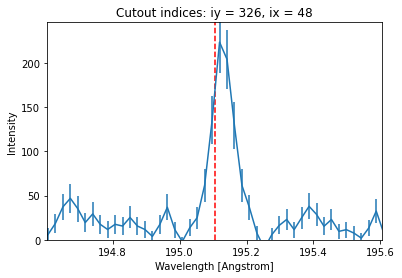

In [ ]:
ix = 48 # pixel index in the x-axis
iy = 326 # pixel index in the y-axis

spec = cube[iy,ix,:] # extract the spectrum from the data cube at one pixel for all wavelengths
spec_inten = spec.data # intensity
spec_wave = spec.wavelength # wavelength
spec_err = spec.uncertainty.array #error


# plot the spectrum
plt.figure()
plt.errorbar(spec_wave, spec_inten, yerr=spec_err, fmt='-')
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Intensity')
plt.title(f'Cutout indices: iy = {iy}, ix = {ix}')
plt.ylim(0, 1.1*np.max(spec_inten))
plt.xlim(template.central_wave - 0.5, template.central_wave + 0.5)
plt.axvline(template.central_wave, color='r', linestyle='--', label=f'{template.central_wave:.2f} [$\AA$]')


We can also plot the quicklook of EIS data - to get the idea on what feature Hinode/EIS was looking at when it made observation.

Note that at this stage, we have not done any analysis yet, so this quicklook can't be used for scientific interpretation.

/var/folders/tp/ymc3q9hn3qjfxm1d5k7q2gp80000gp/T/ipykernel_44117/3189624754.py:4: RuntimeWarning: divide by zero encountered in log10
  scaled_img = np.log10(raster_sum)
/var/folders/tp/ymc3q9hn3qjfxm1d5k7q2gp80000gp/T/ipykernel_44117/3189624754.py:4: RuntimeWarning: invalid value encountered in log10
  scaled_img = np.log10(raster_sum)


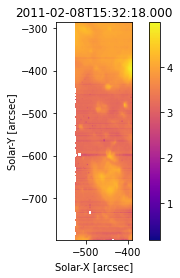

In [ ]:
# sum the data along the wavelength axis to create an image
raster_sum = np.sum(cube.data, axis=2)
# take the log10 of the sum to make the image more visible
scaled_img = np.log10(raster_sum)

plt.figure()
plt.imshow(scaled_img, origin='lower', extent=cube.meta['extent_arcsec'], cmap='plasma')
plt.title(cube.meta['date_obs'][-1])
plt.xlabel('Solar-X [arcsec]')
plt.ylabel('Solar-Y [arcsec]')
plt.colorbar()
plt.show()


## Spectral line fitting
We now fit the line chosen earlier in each pixel of the EIS dataset.

### Pop quiz: Which function is suitable for fitting spectral data, and why??

In [ ]:
# write your answer here (after the # sign)
#

In [ ]:
#check if the fit we want already exists
path = Path(data_filename.replace("data.h5",templates_list[line][0]).replace(".template",f"-{templates_list[line][1]}.fit"))
if path.is_file() == False:
    print('let\'s fit')
    #if the file is not there, fit the line
    cube = eispac.read_cube(data_filename, window=template.central_wave)
    fit_res = eispac.fit_spectra(cube, template, ncpu='max')
    eispac.save_fit(fit_res)
else:
    print('no need to fit')
    #if the file is there already, load it
    cube = eispac.read_cube(data_filename, window=template.central_wave)
    fit_res=eispac.read_fit(path)

no need to fit
Data file,
   /content/drive/MyDrive/EISPACWorkshop/EIS data/eis_20110208_153218.data.h5
Header file,
   /content/drive/MyDrive/EISPACWorkshop/EIS data/eis_20110208_153218.head.h5
Found a wavelength 195.11 [Angstroms] in window 5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   /content/drive/MyDrive/EISPACWorkshop/EIS data/eis_20110208_153218.fe_12_195_119.2c-0.fit.h5


## Some recap while we are waiting for the fitting process.....

We fit spectral lines using a Gaussian function:

$ f(x) = A e^{-\frac{(x-m)^2}{2\sigma^2}}$,

The fitted Gaussian function looks like this:

![Gaussian.png](attachment:Gaussian.png)

### Pop Quiz: How can we use the fitted Gaussian to calculate the emission intensity and the doppler velocity of the plasma?

In [ ]:
# write the formula to calculate these values here....... (after the # sign)
#
#

## Plot the intensity map
During the fitting process, we calculated the spectral line intensity for each pixel. Remember that the spectral line intensity is the area under the Gaussian curve.

INFO:astropy:uncertainty should have attribute uncertainty_type.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


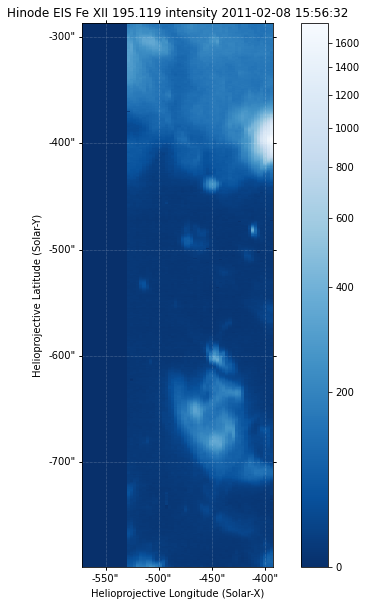

In [ ]:
eismap_intensity = fit_res.get_map(component=templates_list[line][1],measurement='intensity')

plt.figure(figsize=(10, 10))
eismap_intensity.plot()
plt.colorbar()

## Plot the velocity map

During the fitting process, we calculated the spectral line shift for each pixel. Remember that the spectral line shift is the difference between the center of the measured spectral line and the rest wavelength. This gives us information about the plasma velocity.

INFO:astropy:uncertainty should have attribute uncertainty_type.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


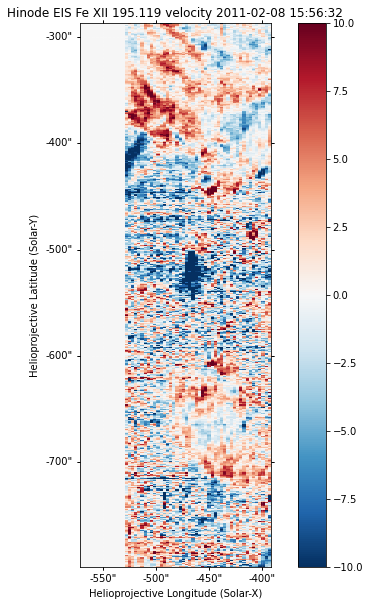

In [ ]:
eismap_velocity = fit_res.get_map(component=templates_list[line][1],measurement='velocity')

plt.figure(figsize=(10, 10))
eismap_velocity.plot()
plt.colorbar()

## Check the line profile from a chosen pixel

You can change the x and y values below to look at the profile of another pixel. Try couple of pixels to see if there are any differences based on the location

In [ ]:
y = -520 # solar-y coordinate in arcsec
x = -465 # solar-x coordinate in arcsec

In [ ]:
# Convert the arcsec coordinates to pixel coordinates
arcsec_coordinate = SkyCoord(x*u.arcsec, y*u.arcsec, frame=eismap_intensity.coordinate_frame)
point_coordinates = eismap_intensity.world_to_pixel(arcsec_coordinate)

# Extract raw data (cube)
data_x = cube.wavelength[int(point_coordinates.y.value), int(point_coordinates.x.value), :]
data_y = cube.data[int(point_coordinates.y.value), int(point_coordinates.x.value), :]
data_err = cube.uncertainty.array[int(point_coordinates.y.value), int(point_coordinates.x.value), :]

# Extract fit profile (fit_res) and interpolate fit at higher spectral resolution
fit_x, fit_y = fit_res.get_fit_profile(coords=[int(point_coordinates.y.value),int(point_coordinates.x.value)], num_wavelengths=100)
c0_x, c0_y = fit_res.get_fit_profile(0, coords=[int(point_coordinates.y.value),int(point_coordinates.x.value)], num_wavelengths=100)
c1_x, c1_y = fit_res.get_fit_profile(1, coords=[int(point_coordinates.y.value),int(point_coordinates.x.value)], num_wavelengths=100)
c2_x, c2_y = fit_res.get_fit_profile(2, coords=[int(point_coordinates.y.value),int(point_coordinates.x.value)], num_wavelengths=100)


# Make a multi-panel figure with the cutout and example profile
fig = plt.figure(figsize=[23,8])
plot_grid = fig.add_gridspec(nrows=1, ncols=3, wspace=0.3)

data_subplt1 = fig.add_subplot(plot_grid[0,0], projection=eismap_intensity)
eismap_intensity.plot(data_subplt1)
data_subplt1.scatter(int(point_coordinates.x.value), int(point_coordinates.y.value), color='r', marker='x')

data_subplt2 = fig.add_subplot(plot_grid[0,1], projection=eismap_velocity)
eismap_velocity.plot(data_subplt2)
data_subplt2.scatter(int(point_coordinates.x.value), int(point_coordinates.y.value), color='r', marker='x')


profile_subplt = fig.add_subplot(plot_grid[0,2])
profile_subplt.errorbar(data_x, data_y, yerr=data_err, ls='', marker='o', color='k')
profile_subplt.plot(fit_x, fit_y, color='b', label='Combined profile')
profile_subplt.plot(c0_x, c0_y, color='r', label=fit_res.fit['line_ids'][0])
profile_subplt.plot(c1_x, c1_y, color='r', ls='--', label=fit_res.fit['line_ids'][1])
profile_subplt.plot(c2_x, c2_y, color='g', label='Background')
profile_subplt.set_title(f'Cutout at: x = {x} \'\', y = {y}\'\'')
profile_subplt.set_xlabel('Wavelength [$\AA$]')
profile_subplt.set_ylabel('Intensity ['+cube.unit.to_string()+']')
profile_subplt.legend(loc='upper left', frameon=False)
profile_subplt.set_xlim(template.central_wave - 0.5, template.central_wave + 0.5)
profile_subplt.axvline(template.central_wave, color='r', linestyle='--', label=f'{template.central_wave:.2f} [$\AA$]')

plt.show()

NameError: name 'x' is not defined

## Draw contours on EIS map
First, define the contour thresholds by intensity.

In [ ]:
intensity_level = [200]

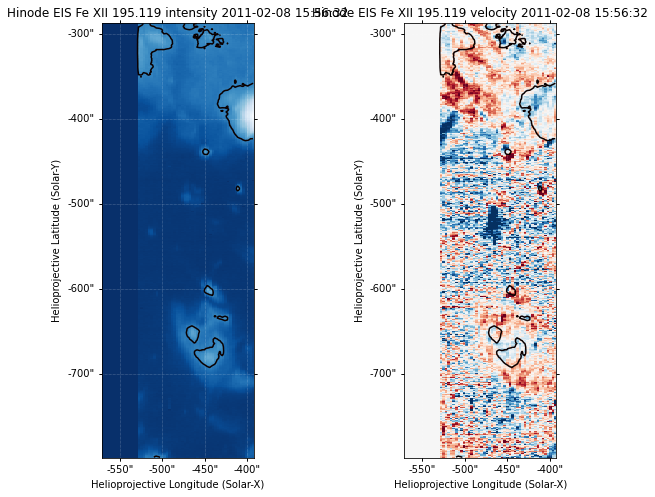

In [ ]:
# Make a multi-panel figure with the cutout and example profile
fig = plt.figure(figsize=[15,8])
plot_grid = fig.add_gridspec(nrows=1, ncols=3, wspace=0.3)

data_subplt1 = fig.add_subplot(plot_grid[0,0], projection=eismap_intensity)
eismap_intensity.plot(data_subplt1)
eismap_intensity.draw_contours(intensity_level*eismap_intensity.unit, axes=data_subplt1, cmap='hot', alpha=1.0)

data_subplt2 = fig.add_subplot(plot_grid[0,1], projection=eismap_velocity)
eismap_velocity.plot(data_subplt2)
eismap_intensity.draw_contours(intensity_level*eismap_intensity.unit, axes=data_subplt2, cmap='hot', alpha=1.0)

### Exercise: find the region with the highest intensity.

In [ ]:
# hint: use your observations and try to varies the intensity_level to see the changes in the plot

Now, define the contour threshold by velocity.

In [ ]:
velocity_level = [-14]

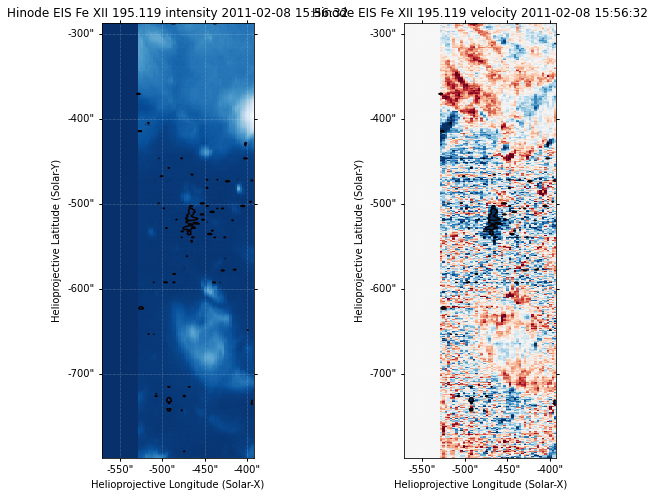

In [ ]:
# Make a multi-panel figure with the cutout and example profile
fig = plt.figure(figsize=[15,8])
plot_grid = fig.add_gridspec(nrows=1, ncols=3, wspace=0.3)

data_subplt1 = fig.add_subplot(plot_grid[0,0], projection=eismap_intensity)
eismap_intensity.plot(data_subplt1)
eismap_velocity.draw_contours(velocity_level*eismap_velocity.unit, axes=data_subplt1, cmap='hot', alpha=1.0)

data_subplt2 = fig.add_subplot(plot_grid[0,1], projection=eismap_velocity)
eismap_velocity.plot(data_subplt2)
eismap_velocity.draw_contours(velocity_level*eismap_velocity.unit, axes=data_subplt2, cmap='hot', alpha=1.0)

### Exercise: find the area with the highest plasma velocity.

In [ ]:
# hint: use your observations and try to varies the velocity_level to see the changes in the plot

### Additional Exercise: if you found this easy, then let's try to use the code blocks in previous section and plot the profiles in the regions with high intensity or high velocity.

In [ ]:
# write your code here

## Bonus: Make a cotemporal AIA map and overplot the field of view of EIS


We first download the AIA data from the Virtual Solar Observatory (VSO).

In [ ]:
time_range = a.Time(parse_time(eismap_intensity.meta['date_beg']),parse_time(eismap_intensity.meta['date_beg'])+30*u.minute) # time range for the AIA data, cooresponding to the EIS data

#Download an AIA 193 map
aia_193 = time_range & a.Instrument.aia & a.Wavelength(193*u.angstrom)
aia_193_search = Fido.search(aia_193)
aia_193_result = Fido.fetch(aia_193_search[0][0])
aia_193_map = sunpy.map.Map(aia_193_result[0])


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

1/0 files failed to download. Please check `.errors` for details


IndexError: ignored

Then we can plot the image of the Sun, with the field-of-view of EIS overplotted on top in red

In [ ]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection=aia_193_map)
aia_193_map.plot(axes=ax)
eismap_intensity.draw_quadrangle(eismap_intensity.bottom_left_coord, top_right = eismap_intensity.top_right_coord, axes=ax, color='r')

That's done for today! Hope this module is helpful to you in learning Solar Physics!